In [339]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from astropy import table
from astropy.table import Table, join
from astropy.io import ascii

import os

import sys
sys.path.append('/Users/nessmayker/Desktop/NessPythonFunctions')
from detectionFraction import detecFrac
from cumulativeDistFunc import makeCDF
from findPercentiles import findStats
from flattenList import flatten

#import SNe data 

SNe_Gal_File = '../Data/3.SNe+GalData.csv'
SNe_Gal_Data = Table.read(SNe_Gal_File, format='csv') 

intenFile = '../Data/3.IntenData.csv'
intenData = Table.read(intenFile, format='csv')

database  = join(SNe_Gal_Data, intenData, keys=('SN_name', 'galaxy'))


In [323]:
database

galaxy,SN_name,SN_type,SN_ra,SN_dec,SN_xCoord,SN_yCoord,SN_co21int,SN_co21err,SN_co21ew,map_beamsize,orient_ra,orient_dec,dist,orient_posang,orient_incl,size_r25,telOrient,NatRes,NatInt,pc60Int,pc90Int,pc120Int,pc150Int,pc500Int,pc750Int,pc1000Int,NatErr,pc60Err,pc90Err,pc120Err,pc150Err,pc500Err,pc750Err,pc1000Err,NatEW,pc60EW,pc90EW,pc120EW,pc150EW,pc500EW,pc750EW,pc1000EW,NatSNR,pc60SNR,pc90SNR,pc120SNR,pc150SNR,pc500SNR,pc750SNR,pc1000SNR,alphaCO
str8,str11,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ngc1566,ASASSN-14ha,II,65.0059,-54.9381,258.9038295074317,423.1062029210927,68.05383,1.8849889,12.188041,0.0003484111476313,65.00159,-54.93801,17.69,214.7,29.5,216.83093,12m+7m+tp,107.5715044627487,68.0538330078125,nan,nan,65.95396423339844,61.926334381103516,27.371265411376953,26.06928253173828,27.377416610717773,1.8849889039993286,nan,nan,1.6742128133773804,1.3591481447219849,0.5764862298965454,0.3906446397304535,0.27018043398857117,12.188040733337402,nan,nan,12.932862281799316,13.762829780578613,19.730430603027344,29.85703468322754,43.81895446777344,36.10304170142571,nan,nan,39.39401473122755,45.56260818335635,47.47947824580116,66.73400804814882,101.33012300911419,4.304510126195559
ngc4321,SN1901B,I,185.6971,15.8238,545.5920792633563,276.5735561756638,5.0824146,1.0344207,2.544713,0.000462934650464,185.72887,15.822304,15.21,156.2,38.5,182.86105,12m+7m+tp,122.89275219530901,5.6628522872924805,nan,nan,5.6628522872924805,5.4790143966674805,6.016371250152588,5.822849273681641,5.013950347900391,1.029056191444397,nan,nan,1.029056191444397,0.8251489996910095,0.23007987439632416,0.13967318832874298,0.08780597150325775,2.744281053543091,nan,nan,2.744281053543091,4.029609203338623,10.151252746582031,13.131563186645508,13.50499439239502,5.502957306290559,nan,nan,5.502957306290559,6.640030344482253,26.149054826886275,41.68909826828498,57.102612294590514,7.542486704286047
ngc5236,SN1923A,II,204.2883,-29.8389,399.09014170428725,813.7841220160797,3.1662843,0.6370633,6.310522,0.000594044605435,204.2539,-29.865625,4.89,225.0,24.0,408.43347,12m+7m+tp,50.69968757298903,3.1662843227386475,2.982912540435791,2.6480391025543213,2.569227695465088,2.6020655632019043,4.148641109466553,4.5491557121276855,5.028407096862793,0.6370633244514465,0.5877888202667236,0.46251943707466125,0.36471322178840637,0.2875167727470398,0.03622424229979515,0.017963431775569916,0.015305337496101856,6.310522079467773,5.9792962074279785,5.600820541381836,6.416561603546143,7.461651802062988,6.986499786376953,7.857295036315918,8.778962135314941,4.970124948669784,5.07480312245854,5.725249341525223,7.044514818702302,9.050134843754762,114.52664972622529,253.2453580676322,328.5394456766136,6.692307692307692
ngc4303,SN1926A,II,185.4754,4.4934,248.12510207394456,387.43756648042245,-0.81909573,0.8172306,nan,0.000503635821363,185.47888,4.473744,16.99,312.4,23.5,206.59573,12m+7m+tp,149.34385530047734,-0.7315931916236877,nan,nan,nan,-0.7315931916236877,0.13160844147205353,0.38786447048187256,0.5659606456756592,0.8364595770835876,nan,nan,nan,0.8364595770835876,0.30151838064193726,0.19038888812065125,0.1036238819360733,nan,nan,nan,nan,nan,nan,nan,1.8840171098709106,-0.8746306595884423,nan,nan,nan,-0.8746306595884423,0.43648563378410676,2.0372222050904525,5.461681565112629,6.037231630177928
ngc1511,SN1935C,unclassified,59.9373,-67.6374,112.46713980638378,194.45954575675466,2.5883038,0.76610756,nan,0.0004017774799122,59.90246,-67.63393,15.28,297.0,72.7,110.94844,12m+7m+tp,107.1485534400328,2.5365307331085205,nan,nan,2.2158656120300293,1.6356202363967896,0.9448716640472412,1.5689282417297363,1.971544861793518,0.7649294137954712,nan,nan,0.64976251

In [324]:
# Find which SNe have nan values and which have finite
nans   = np.argwhere(np.isnan(database["pc150Int"]))
finite = np.argwhere(np.isfinite(database["pc150Int"]))

numSNe    = len(database["pc150Int"])
numFinite = len(finite)
numNans   = len(nans)

# Create array of intensity, errpr, & SNR values where measurements are finite
SNRvalues    = database["pc150SNR"][finite]
values       = database["pc150Int"][finite]
errors       = database["pc150Err"][finite]
alphaCO_Sun  = database["alphaCO"][finite]

# Find which are considered non-detections and which are detections
detections_idx, um    = np.where(SNRvalues >= 3.0)
nondetections_idx, um = np.where(SNRvalues < 3.0)

detections_int    = flatten(values[detections_idx])

nondetections_int = flatten(values[nondetections_idx])

numDetect    = len(detections_int)
numNonDetect = len(nondetections_int)

# assign nondetections upper limits as a value of 3x the noise.
nondetections_ul = flatten(3 * errors[nondetections_idx])

print("Out of", numSNe, "supernovae,", numFinite, "or", round(numFinite/numSNe*100, 0), "percent of the sample are within the PHANGS-ALMA footprint at 150pc resolution.")
print("Out of these,", numDetect, "or", round(numDetect/numFinite*100, 0), "percent of the sample have a SNR of 3.0 or greater and are classified as coinciding in areas with detectable CO2-1 emission.")
print("The remaining", numNonDetect, "are assigned an upper limit CO2-1 intensity measurement of 3 times the noise value at their location.")


Out of 66 supernovae, 62 or 94.0 percent of the sample are within the PHANGS-ALMA footprint at 150pc resolution.
Out of these, 37 or 60.0 percent of the sample have a SNR of 3.0 or greater and are classified as coinciding in areas with detectable CO2-1 emission.
The remaining 25 are assigned an upper limit CO2-1 intensity measurement of 3 times the noise value at their location.


In [325]:
# Sort measurements by SN Type and separate detections from nondetections.

SNtypes = database["SN_type"][finite]

typeII_idx, um    = np.where(SNtypes=="II")
typeIa_idx, um    = np.where(SNtypes=="Ia")
typeIb_idx, um    = np.where(SNtypes=="Ib")
typeIc_idx, um    = np.where(SNtypes=="Ic")
typeIbIc_idx, um   = np.where(SNtypes=="Ib/c")
typeIbc_idx = np.concatenate((typeIb_idx, typeIc_idx, typeIbIc_idx), axis = 0)
typeIbc_idx.sort()  
typeI_idx, um = np.where(SNtypes=="I")
typeUnk_idx, um = np.where(SNtypes=="unclassified")
typeUnC_idx = np.concatenate((typeI_idx, typeUnk_idx), axis = 0)
typeUnC_idx.sort()

numTypeII  = len(typeII_idx)
numTypeIa  = len(typeIa_idx)
numTypeIbc = len(typeIbc_idx)
numTypeUnC = len(typeUnC_idx)

# find indicies of each SN type where there is both a detection and nondetection
detectionsII_idx = np.intersect1d(typeII_idx, detections_idx)
nondetectionsII_idx = np.intersect1d(typeII_idx, nondetections_idx)
numtypeIId  = len(detectionsII_idx)
numtypeIInd = len(nondetectionsII_idx)
detectionsII_int = flatten(values[detectionsII_idx])
nondetectionsII_ul = flatten(3 * errors[nondetectionsII_idx])

detectionsIa_idx = np.intersect1d(typeIa_idx, detections_idx)
nondetectionsIa_idx = np.intersect1d(typeIa_idx, nondetections_idx)
numtypeIad  = len(detectionsIa_idx)
numtypeIand = len(nondetectionsIa_idx)
detectionsIa_int = flatten(values[detectionsIa_idx])
nondetectionsIa_ul = flatten(3 * errors[nondetectionsIa_idx])

detectionsIbc_idx = np.intersect1d(typeIbc_idx, detections_idx)
nondetectionsIbc_idx = np.intersect1d(typeIbc_idx, nondetections_idx)
numtypeIbcd  = len(detectionsIbc_idx)
numtypeIbcnd = len(nondetectionsIbc_idx)
detectionsIbc_int = flatten(values[detectionsIbc_idx])
nondetectionsIbc_ul = flatten(3 * errors[nondetectionsIbc_idx])

detectionsUnC_idx = np.intersect1d(typeUnC_idx, detections_idx)
nondetectionsUnC_idx = np.intersect1d(typeUnC_idx, nondetections_idx)
numtypeUnCd  = len(detectionsUnC_idx)
numtypeUnCnd = len(nondetectionsUnC_idx)
detectionsUnC_int = flatten(values[detectionsUnC_idx])
nondetectionsUnC_ul = flatten(3 * errors[nondetectionsUnC_idx])


# This is how to access these indexed lists
# print(database["SN_type"][finite][typeIIdetections_idx])

print("We have ", round(numtypeIId/numTypeII * 100,0), "percent CO 2-1 detections at the location of our",  numTypeII, "typeII SNe.")
print("We have ", round(numtypeIad/numTypeIa * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIa, "typeIa SNe.")
print("We have ", round(numtypeIbcd/numTypeIbc * 100,0), "percent CO 2-1 detections at the location of our",  numTypeIbc, "typeIb/c SNe.")
print("We have ", round(numtypeUnCd/numTypeUnC * 100,0), "percent CO 2-1 detections at the location of our",  numTypeUnC, "untyped SNe.")


We have  56.0 percent CO 2-1 detections at the location of our 36 typeII SNe.
We have  33.0 percent CO 2-1 detections at the location of our 12 typeIa SNe.
We have  86.0 percent CO 2-1 detections at the location of our 7 typeIb/c SNe.
We have  100.0 percent CO 2-1 detections at the location of our 7 untyped SNe.


In [326]:
# Make CDFs of detections and by each type.

frac = numNonDetect/numFinite
fracII = numtypeIInd/numTypeII
fracIa = numtypeIand/numTypeIa
fracIbc = numtypeIbcnd/numTypeIbc
fracUnC = numtypeUnCnd/numTypeUnC

def yStart(numSample):
    start = 1.0/numSample
    return(start)

startAll = yStart(numFinite)       
CDFdetection, ydetection       = makeCDF(detections_int, min=frac+startAll)
CDFnondetection, ynondetection = makeCDF(nondetections_ul, min = startAll, max=frac)

startII = yStart(numTypeII)      
CDFdetectionII, ydetectionII      = makeCDF(detectionsII_int, min=fracII+startII)
CDFnodetectionII, ynondetectionII = makeCDF(nondetectionsII_ul, min = startII, max=fracII)

startIa = yStart(numTypeIa)       
CDFdetectionIa, ydetectionIa      = makeCDF(detectionsIa_int, min=fracIa+startIa)
CDFnodetectionIa, ynondetectionIa = makeCDF(nondetectionsIa_ul, min = startIa, max=fracIa)

startIbc = yStart(numTypeIbc)       
CDFdetectionIbc, ydetectionIbc      = makeCDF(detectionsIbc_int, min=fracIbc+startIbc)
CDFnodetectionIbc, ynondetectionIbc = makeCDF(nondetectionsIbc_ul, min = startIbc, max=fracIbc)

startUnC = yStart(numTypeUnC)       
CDFdetectionUnC, ydetectionUnC      = makeCDF(detectionsUnC_int, min=fracUnC+startUnC)
CDFnodetectionUnC, ynondetectionUnC = makeCDF(nondetectionsUnC_ul, min = startUnC, max=fracUnC)


In [327]:
# Convert to molecular gas surface density using constant alphaCO

alphaCO = 4.35/0.65

detections_mgsd_ca       = [x * alphaCO for x in detections_int]
nondetections_mgsd_ca    = [x * alphaCO for x in nondetections_ul]

detectionsII_mgsd_ca     = [x * alphaCO for x in detectionsII_int]
nondetectionsII_mgsd_ca  = [x * alphaCO for x in nondetectionsII_ul]

detectionsIa_mgsd_ca     = [x * alphaCO for x in detectionsIa_int]
nondetectionsIa_mgsd_ca  = [x * alphaCO for x in nondetectionsIa_ul]

detectionsIbc_mgsd_ca    = [x * alphaCO for x in detectionsIbc_int]
nondetectionsIbc_mgsd_ca = [x * alphaCO for x in nondetectionsIbc_ul]

detectionsUnC_mgsd_ca    = [x * alphaCO for x in detectionsUnC_int]
nondetectionsUnC_mgsd_ca = [x * alphaCO for x in nondetectionsUnC_ul]

CDFdetection_mgsd_ca, ydetection_mgsd_ca            = makeCDF(detections_mgsd_ca, min=frac+startAll)
CDFnondetection_mgsd_ca, ynondetection_mgsd_ca      = makeCDF(nondetections_mgsd_ca, min = startAll, max=frac)

CDFdetectionII_mgsd_ca, ydetectionII_mgsd_ca        = makeCDF(detectionsII_mgsd_ca, min=fracII+startII)
CDFnodetectionII_mgsd_ca, ynondetectionII_mgsd_ca   = makeCDF(nondetectionsII_mgsd_ca, min = startII, max=fracII)

CDFdetectionIa_mgsd_ca, ydetectionIa_mgsd_ca        = makeCDF(detectionsIa_mgsd_ca, min=fracIa+startIa)
CDFnodetectionIa_mgsd_ca, ynondetectionIa_mgsd_ca   = makeCDF(nondetectionsIa_mgsd_ca, min = startIa, max=fracIa)

CDFdetectionIbc_mgsd_ca, ydetectionIbc_mgsd_ca      = makeCDF(detectionsIbc_mgsd_ca, min=fracIbc+startIbc)
CDFnodetectionIbc_mgsd_ca, ynondetectionIbc_mgsd_ca = makeCDF(nondetectionsIbc_mgsd_ca, min = startIbc, max=fracIbc)

CDFdetectionUnC_mgsd_ca, ydetectionUnC_mgsd_ca      = makeCDF(detectionsUnC_mgsd_ca, min=fracUnC+startUnC)
CDFnodetectionUnC_mgsd_ca, ynondetectionUnC_mgsd_ca = makeCDF(nondetectionsUnC_mgsd_ca, min = startUnC, max=fracUnC)



In [328]:
# Convert to molecular gas surface density using Sun+20 alphaCO


detections_mgsd_mda       = [a*b for a,b in zip(detections_int, flatten(alphaCO_Sun[detections_idx]))]
nondetections_mgsd_mda    = [a*b for a,b in zip(nondetections_ul, flatten(alphaCO_Sun[nondetections_idx]))]

detectionsII_mgsd_mda     = [a*b for a,b in zip(detectionsII_int, flatten(alphaCO_Sun[detectionsII_idx]))]
nondetectionsII_mgsd_mda  = [a*b for a,b in zip(nondetectionsII_ul, flatten(alphaCO_Sun[nondetectionsII_idx]))]

detectionsIa_mgsd_mda     = [a*b for a,b in zip(detectionsIa_int, flatten(alphaCO_Sun[detectionsIa_idx]))]
nondetectionsIa_mgsd_mda  = [a*b for a,b in zip(nondetectionsIa_ul, flatten(alphaCO_Sun[nondetectionsIa_idx]))]

detectionsIbc_mgsd_mda    = [a*b for a,b in zip(detectionsIbc_int, flatten(alphaCO_Sun[detectionsIbc_idx]))]
nondetectionsIbc_mgsd_mda = [a*b for a,b in zip(nondetectionsIbc_ul, flatten(alphaCO_Sun[nondetectionsIbc_idx]))]

detectionsUnC_mgsd_mda    = [a*b for a,b in zip(detectionsUnC_int, flatten(alphaCO_Sun[detectionsUnC_idx]))]
nondetectionsUnC_mgsd_mda = [a*b for a,b in zip(nondetectionsUnC_ul, flatten(alphaCO_Sun[nondetectionsUnC_idx]))]

CDFdetection_mgsd_mda, ydetection_mgsd_mda       = makeCDF(detections_mgsd_mda, min=frac+startAll)
CDFnondetection_mgsd_mda, ynondetection_mgsd_mda = makeCDF(nondetections_mgsd_mda, min = startAll, max=frac)

CDFdetectionII_mgsd_mda, ydetectionII_mgsd_mda      = makeCDF(detectionsII_mgsd_mda, min=fracII+startII)
CDFnodetectionII_mgsd_mda, ynondetectionII_mgsd_mda = makeCDF(nondetectionsII_mgsd_mda, min = startII, max=fracII)

CDFdetectionIa_mgsd_mda, ydetectionIa_mgsd_mda      = makeCDF(detectionsIa_mgsd_mda, min=fracIa+startIa)
CDFnodetectionIa_mgsd_mda, ynondetectionIa_mgsd_mda = makeCDF(nondetectionsIa_mgsd_mda, min = startIa, max=fracIa)

CDFdetectionIbc_mgsd_mda, ydetectionIbc_mgsd_mda      = makeCDF(detectionsIbc_mgsd_mda, min=fracIbc+startIbc)
CDFnodetectionIbc_mgsd_mda, ynondetectionIbc_mgsd_mda = makeCDF(nondetectionsIbc_mgsd_mda, min = startIbc, max=fracIbc)

CDFdetectionUnC_mgsd_mda, ydetectionUnC_mgsd_mda      = makeCDF(detectionsUnC_mgsd_mda, min=fracUnC+startUnC)
CDFnodetectionUnC_mgsd_mda, ynondetectionUnC_mgsd_mda = makeCDF(nondetectionsUnC_mgsd_mda, min = startUnC, max=fracUnC)



In [329]:
# Convert MGSD to Mass

area = (150.0/2.0)**2*np.pi/np.log(2.0)

def mgsd2mass(x):
    y = np.log10(area) + x
    return(y)

def mass2mgsd(x):
    y = x - np.log10(area)
    return(y)

def makeLog(inputArr):
    outputArr = []
    for i in range(len(inputArr)):
        if(inputArr[i] <= 1.0):
            outputArr.append(0.0)
        else:
            outputArr.append(np.log10(inputArr[i])) 
    return(outputArr)



Text(90, 129, '$\\alpha_{CO}$: Sun+20')

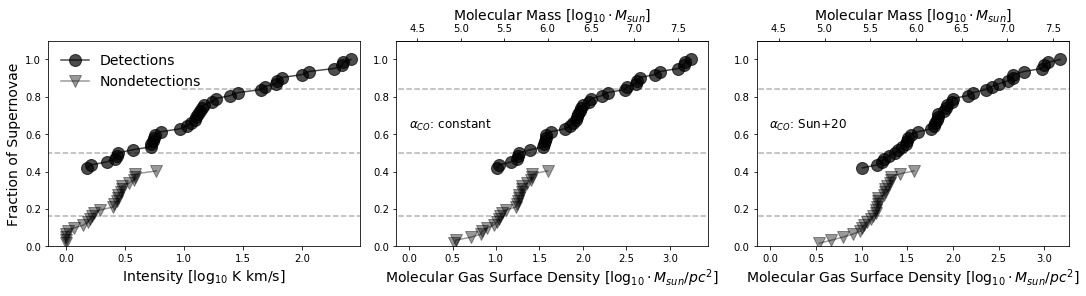

In [330]:
# Convert functions to log for plot

logCDFnondetection          = makeLog(CDFnondetection)
logCDFnondetection_mgsd_ca  = makeLog(CDFnondetection_mgsd_ca)
logCDFnondetection_mgsd_mda = makeLog(CDFnondetection_mgsd_mda)
logCDFdetection             = makeLog(CDFdetection)
logCDFdetection_mgsd_ca     = makeLog(CDFdetection_mgsd_ca)
logCDFdetection_mgsd_mda    = makeLog(CDFdetection_mgsd_mda)

ms = 12
fs = 14

fig, axs = plt.subplots(1, 3, sharex=False, constrained_layout=True)
fig.set_figheight(4)
fig.set_figwidth(15)
axs[0].plot(logCDFdetection, ydetection, color = 'k', marker = 'o', label = 'Detections', ms = ms, alpha = 0.7)
axs[0].plot(logCDFnondetection, ynondetection, color = 'k', marker = 'v', ms = ms, label = 'Nondetections', alpha = 0.4)
axs[0].axhline(y=0.16, xmin=-0.3, xmax = CDFdetection[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.50, xmin=-0.3, xmax = CDFdetection[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.84, xmin=0.43, xmax = CDFdetection[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].legend(frameon=False,loc='upper left', fontsize = fs,facecolor='white', framealpha=1)
axs[0].set_xlim(-0.15, np.log10(CDFdetection[-1] + 50))
axs[0].set_xlabel(r'Intensity [$\log_{10}$ K km/s]', fontsize = fs)
axs[0].set_ylabel('Fraction of Supernovae', fontsize = fs)
axs[0].set_ylim(0.0, 1.1)


axs[1].plot(logCDFdetection_mgsd_ca, ydetection_mgsd_ca, color = 'k',marker = 'o', ms = ms, alpha = 0.7)
axs[1].plot(logCDFnondetection_mgsd_ca, ynondetection_mgsd_ca, color = 'k', marker = 'v', ms = ms, alpha = 0.4)
axs[1].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_ca[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_ca[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_ca[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 14)
secax1 = axs[1].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
axs[1].annotate(r'$\alpha_{CO}$: constant', xy=(95, 129), xycoords='axes points',
            size=12, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))
secax1.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = fs)
axs[1].set_xlim(-0.15, np.log10(CDFdetection_mgsd_ca[-1] + 1000))
axs[1].set_ylim(0.0, 1.1)


axs[2].plot(logCDFdetection_mgsd_mda, ydetection_mgsd_mda, marker = 'o', ms = ms, color = 'k', alpha = 0.7)
axs[2].plot(logCDFnondetection_mgsd_mda, ynondetection_mgsd_mda, marker = 'v',color = 'k', ms = ms, alpha = 0.4)
axs[2].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_mda[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_mda[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_mda[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 14)
secax2 = axs[2].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
secax2.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = fs)
axs[2].set_xlim(-0.15, np.log10(CDFdetection_mgsd_ca[-1] + 100))
axs[2].set_ylim(0.0, 1.1)
axs[2].annotate(r'$\alpha_{CO}$: Sun+20', xy=(90, 129), xycoords='axes points',
            size=12, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))



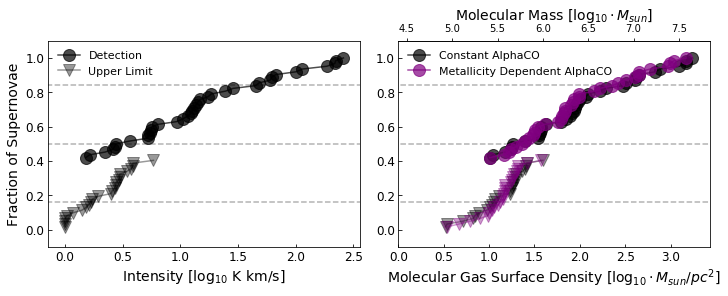

In [331]:
# Put alphaCOs on same plot

ms = 12
fs = 14

fig, axs = plt.subplots(1,2, sharex=False, constrained_layout=True)
fig.set_figheight(4)
fig.set_figwidth(10)
axs[0].plot(logCDFdetection, ydetection, color = 'k', marker = 'o', label = 'Detection', ms = ms, alpha = 0.7)
axs[0].plot(logCDFnondetection, ynondetection, color = 'k', marker = 'v', ms = ms, label = 'Upper Limit', alpha = 0.4)
axs[0].axhline(y=0.16, xmin=-0.3, xmax = CDFdetection[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.50, xmin=-0.3, xmax = CDFdetection[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.84, xmin=-0.3, xmax = CDFdetection[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].legend(frameon=False,loc='upper left', fontsize = 11,facecolor='white', framealpha=1)
axs[0].set_xlim(-0.15, np.log10(CDFdetection[-1] + 100))
axs[0].set_xlabel(r'Intensity [$\log_{10}$ K km/s]', fontsize = fs)
axs[0].set_ylabel('Fraction of Supernovae', fontsize = fs)
axs[0].tick_params(axis='both', direction = "in", labelsize = 12)
axs[0].set_ylim(-0.1, 1.1)


axs[1].plot(logCDFdetection_mgsd_ca, ydetection_mgsd_ca, color = 'k',marker = 'o', ms = ms, alpha = 0.7, label="Constant AlphaCO")
axs[1].plot(logCDFnondetection_mgsd_ca, ynondetection_mgsd_ca, color = 'k', marker = 'v', ms = ms, alpha = 0.4)
axs[1].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_ca[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_ca[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetection_mgsd_ca[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = fs)
secax1 = axs[1].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
secax1.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = fs)
axs[1].set_xlim(0.0, np.log10(CDFdetection_mgsd_ca[-1] + 1000))
axs[1].set_ylim(-0.1, 1.1)
axs[1].plot(logCDFdetection_mgsd_mda, ydetection_mgsd_mda, marker = 'o', ms = ms, color = 'purple', alpha = 0.7, label="Metallicity Dependent AlphaCO")
axs[1].plot(logCDFnondetection_mgsd_mda, ynondetection_mgsd_mda, marker = 'v',color = 'purple', ms = ms, alpha = 0.4)
axs[1].legend(frameon=False,loc='upper left', fontsize = 11,facecolor='white', framealpha=1)
axs[1].tick_params(axis='both', direction = "in", labelsize = 12)

plt.savefig('../Figures/COEmissionCDFs.png')

In [341]:
########### GETTING ALL PIXEL VALUES HERE #################

# filename: /data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc2997/ngc2997_12m+7m+tp_co21_150pc_broad_mom0.fits

# Isolate unique galaxy names
unique_by_name = table.unique(database, keys='galaxy')
filename = []

# Create list of Filenames
for i in range(len(unique_by_name)):
    prefix = "/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/"
    galaxy = unique_by_name['galaxy'][i]
    telOrient = unique_by_name['telOrient'][i]
    suffix = "_co21_150pc_broad_mom0.fits"
    name =  prefix + galaxy + "/" + galaxy + "_" + telOrient + suffix
    filename.append(name)
    
# Pull intensity values out of galaxy maps for CDF    
for i in range(len(filename)):
    if os.path.isfile(filename[i]):
        hdulist  = pyfits.open(filename[i])
        map      = hdulist[0].data 
        f_int    = map.flatten()
        keep     = np.where(np.isfinite(f_int))
        inten    = f_int[keep]


['/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0253/ngc0253_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0300/ngc0300_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0628/ngc0628_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1068/ngc1068_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1087/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1097/ngc1097_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1365/ngc1365_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1433/ngc1433_12m+7m+tp_co21_150pc_broad

NameError: name 'inten' is not defined

In [ ]:
        
        
# Will probably need       
#     area = (150.0/2.0)**2*np.pi/np.log(2.0)

#     hdulist2  = pyfits.open(errimage)
#     map2      = hdulist2[0].data

#     if(alphaCOimg) != 'no file':
#         hdulist3  = pyfits.open(alphaCOimg)
#         map3      = hdulist3[0].data
#         # make mass map
#         map4      = map * map3 * area
#     else: map4 = map * 6.7 * area
    
#     wcs      = WCS(hdulist[0].header, naxis=2)
#     naxis    = wcs._naxis # size of image naxis[0] = x and [1] = y
#     grid     = np.indices((naxis[1],naxis[0]))
#     ra, dec  = wcs.wcs_pix2world(grid[1],grid[0],0)

#     #deproject ra and dec to dx and dy
#     radius, projang, dx, dy = deproject(center_coord=centerCoord, incl=incl, pa=pa, ra=ra, dec=dec,return_offset=True)
#     plt.imshow(map, origin='lower', interpolation='nearest', zorder=1)
    
    #flatten data structures 
#     f_err  = map2.flatten()
#     f_mass = map4.flatten()
#     f_ra   = ra.flatten()
#     f_dec  = dec.flatten()    
#     f_dx   = dx.flatten()
#     f_dy   = dy.flatten()
        
#     if(alphaCOimg) != 'no file':
#         f_aco = map3.flatten()
        
    
    #remove nans
#    keep  = np.where(np.isfinite(f_int))
#     ra    = f_ra[keep]
#     dec   = f_dec[keep]
#     inten = f_int[keep]
#     err   = f_err[keep]
#     mass  = f_mass[keep]
#     dx    = f_dx[keep]
#     dy    = f_dy[keep]
    
#     if(alphaCOimg) != 'no file':
#         aco   = f_aco[keep]
#     else:
#         aco = []
#         for i in range(len(err)):
#             aco.append(6.7)
    
#     SNR = []
#     for i in range(len(inten)):
#         if err[i] == 0.0:
#             SNR.append(0.0)
#         elif inten[i] < 0.0:
#             SNR.append(0.0)           
#         else:
#             SNR.append(inten[i]/err[i])       
    
#     return(inten, err, aco, mass, SNR, ra, dec, dx, dy)




In [338]:
print(filename)

['/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/circinus/circinus_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0253/ngc0253_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0300/ngc0300_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc0628/ngc0628_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1068/ngc1068_7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1087/ngc1087_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1097/ngc1097_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1365/ngc1365_12m+7m+tp_co21_150pc_broad_mom0.fits', '/data/tycho/0/leroy.42/reduction/alma/phangs-alma/derived/ngc1433/ngc1433_12m+7m+tp_co21_150pc_broad

In [254]:
#losDetecCDFs, ylosDetec, losNoDetecCDFs, ylosNoDetec = np.genfromtxt('../Data/universalCDF.txt', dtype = object, unpack=True, delimiter = ' ', usecols=(0,1,2,3))
ints, uncerts, alphas = np.genfromtxt('../Data/allIntVals.txt', unpack=True, usecols=(1,2,3))

# make universal CDF
intDetec, intNoDetec, alphaDetec, alphaNoDetec = [],[],[],[]

for i in range(len(ints)):
    intensity = ints[i]
    uncert = uncerts[i]
    
    if uncert == 0.0:
        ratio = 0.0
    else:
        ratio = intensity/uncert

    if ratio >= 3.0:
        intDetec.append(intensity)
        alphaDetec.append(alphas[i])
    else:
        intNoDetec.append(3.0 * uncert)
        alphaNoDetec.append(alphas[i])


OSError: ../Data/allIntVals.txt not found.

In [ ]:
# make CDFs for figure 2

#Plot 1: Intensity
frac = len(intNoDetec)/(len(intNoDetec + intDetec))    

detecCDF,   ydetec   = makeCDF(intDetec, min=frac)
nodetecCDF, ynodetec = makeCDF(intNoDetec, min = 0.0, max=frac) 

lognodetecCDF = makeLog(nodetecCDF)
logdetecCDF   = makeLog(detecCDF)

#Plot 2: Sigma Mol(Constant alpha CO)
sigmaDetec, sigmaNoDetec = [],[]

for i in range(len(detecCDF)):
    sigmaDetec.append(detecCDF[i] * alphaCO)
for i in range(len(nodetecCDF)):
    sigmaNoDetec.append(nodetecCDF[i] * alphaCO)

logSigmaDetecCDF   = makeLog(sigmaDetec)
logSigmaNoDetecCDF = makeLog(sigmaNoDetec)


#Plot 3: Sigma Mol(alpha CO Sun+20)
sigmaDetecSun, sigmaNoDetecSun = [],[]
for i in range(len(intDetec)):
    sigmaDetecSun.append(intDetec[i]*alphaDetec[i])
for i in range(len(intNoDetec)):
    sigmaNoDetecSun.append(intNoDetec[i]*alphaNoDetec[i])

sigmaDetecSunCDF,   ysigdetec   = makeCDF(sigmaDetecSun, min=frac)
sigmaNoDetecSunCDF, ysignodetec = makeCDF(sigmaNoDetecSun, min = 0.0, max=frac) 

logSigmaDetecSunCDF   = makeLog(sigmaDetecSunCDF)
logSigmaNoDetecSunCDF = makeLog(sigmaNoDetecSunCDF)

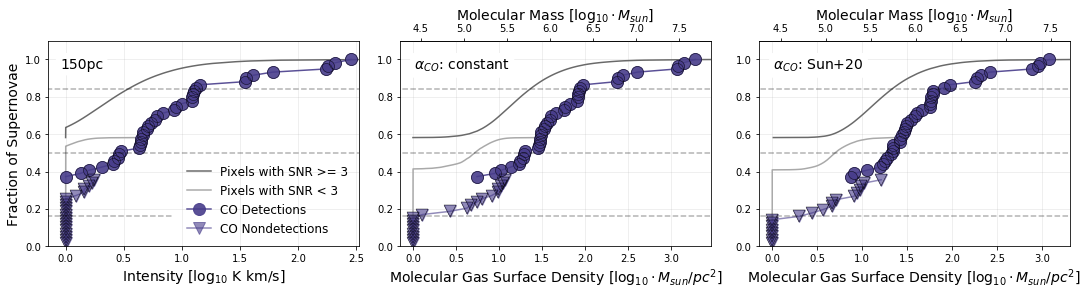

In [9]:
# Make Figure 2
fig, axs = plt.subplots(1, 3, sharex=False, constrained_layout=True)
fig.set_figheight(4)
fig.set_figwidth(15)

axs[0].plot(logdetecCDF, ydetec, color = 'dimgrey', linestyle = '-', label = 'Pixels with SNR >= 3')
axs[0].plot(lognodetecCDF, ynodetec, color = 'darkgrey', linestyle = '-', label = 'Pixels with SNR < 3')
axs[0].plot(logCDFa, ydetec1, color = 'darkslateblue',marker = 'o', ms = 12, alpha = 0.9, label = 'CO Detections')
axs[0].plot(logCDF1, ynodetec1, color = 'darkslateblue', marker = 'v', ms = 12, alpha = 0.6, label = 'CO Nondetections')
axs[0].plot(logCDFa, ydetec1, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)
axs[0].plot(logCDF1, ynodetec1, color = 'None', marker = 'v', ms = 12, mec = 'k', mew = 0.4)
axs[0].axhline(y=0.16, xmin=-0.3, xmax = 0.4, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.50, xmin=-0.3, xmax = CDFdetec1[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.84, xmin=-0.3, xmax = CDFdetec1[-1]+50, ls = '--', color = 'k', alpha = 0.3)
axs[0].legend(frameon=False,loc='best', fontsize = 12,facecolor='white', framealpha=1)
axs[0].set_xlim(-0.15, np.log10(CDFdetec1[-1] + 50))
axs[0].set_xlabel(r'Intensity [$\log_{10}$ K km/s]', fontsize = 14)
axs[0].set_ylabel('Fraction of Supernovae', fontsize = 14)
axs[0].annotate('150pc', xy=(55, 189), xycoords='axes points',
            size=14, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))
axs[0].grid(True, alpha = 0.25)
axs[0].set_ylim(0.0, 1.1)

axs[1].plot(logSigmaDetecCDF, ydetec, color = 'dimgrey', linestyle = '-')
axs[1].plot(logSigmaNoDetecCDF, ynodetec, color = 'darkgrey', linestyle = '-')
axs[1].plot(np.log10(CDFdetec2), ydetec2, color = 'darkslateblue',marker = 'o', ms = 12, alpha = 0.9)
axs[1].plot(logCDF2, ynodetec2, color = 'darkslateblue', marker = 'v', ms = 12, alpha = 0.6)
axs[1].plot(np.log10(CDFdetec2), ydetec2, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)
axs[1].plot(logCDF2, ynodetec2, color = 'None', marker = 'v', ms = 12, mec = 'k', mew = 0.4)
axs[1].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetec2[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetec2[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetec2[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 14)
secax1 = axs[1].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
axs[1].annotate(r'$\alpha_{CO}$: constant', xy=(110, 189), xycoords='axes points',
            size=14, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))
secax1.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 14)
axs[1].set_xlim(-0.15, np.log10(CDFdetec2[-1] + 1000))
axs[1].grid(True, alpha = 0.25)
axs[1].set_ylim(0.0, 1.1)

axs[2].plot(logSigmaDetecSunCDF, ysigdetec, color = 'dimgrey', linestyle = '-')
axs[2].plot(logSigmaNoDetecSunCDF, ysignodetec, color = 'darkgrey', linestyle = '-')
axs[2].plot(np.log10(CDFdetec3), ydetec3, color = 'darkslateblue',marker = 'o', ms = 12, alpha = 0.9)
axs[2].plot(logCDF3, ynodetec3, color = 'darkslateblue', marker = 'v', ms = 12, alpha = 0.6)
axs[2].plot(np.log10(CDFdetec3), ydetec3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)
axs[2].plot(logCDF3, ynodetec3, color = 'None', marker = 'v', ms = 12, mec = 'k', mew = 0.4)
axs[2].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetec3[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetec3[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetec3[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 14)
secax2 = axs[2].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
secax2.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 14)
axs[2].set_xlim(-0.15, np.log10(CDFdetec2[-1] + 100))
axs[2].set_ylim(0.0, 1.1)
axs[2].grid(True, alpha = 0.25)
axs[2].annotate(r'$\alpha_{CO}$: Sun+20', xy=(105, 189), xycoords='axes points',
            size=14, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))

plt.savefig('../Figures/COEmissionCDFs.png')



In [19]:

Yarray1b = np.concatenate((ynodetec, ydetec))
Xarray1b = np.concatenate((lognodetecCDF, logdetecCDF))

Yarray1 = np.concatenate((ynodetec1, ydetec1))
Xarray1 = np.concatenate((logCDF1, logCDFa))

Xarray2b = np.concatenate((logSigmaNoDetecCDF, logSigmaDetecCDF))
Xarray3b = np.concatenate((logSigmaNoDetecSunCDF, logSigmaDetecSunCDF))

Yarray2 = np.concatenate((ynodetec2, ydetec2))
Xarray2 = np.concatenate((logCDF2, np.log10(CDFdetec2)))

Yarray3 = np.concatenate((ynodetec3, ydetec3))
Xarray3 = np.concatenate((logCDF3, np.log10(CDFdetec3)))


stats1  = findStats(Yarray1, Xarray1)
stats2  = findStats(Yarray2, Xarray2)
stats3  = findStats(Yarray3, Xarray3)
stats1b  = findStats(Yarray1b, Xarray1b)
stats2b  = findStats(Yarray1b, Xarray2b)
stats3b  = findStats(Yarray1b, Xarray3b)

print("Topic   Percentiles:[0.05, 0.16, 0.50, 0.84, 0.95]")
print("All Intensity:", stats1b)
print("SNe Intensity:", stats1)
print()
print("All Constant AlphaCO:", stats2b)
print("Constant AlphaCO:", stats2)
print()
print("All Sun+20 AlphaCO:", stats3b)
print("Sun+20 AlphaCO:", stats3)

print(np.mean(Xarray3b))
print(np.mean(Xarray3))

Topic   Percentiles:[0.05, 0.16, 0.50, 0.84, 0.95]
All Intensity: [0.0, 0.0, 0.0, 0.53, 0.98]
SNe Intensity: [0.0, 0.0, 0.46, 1.12, 2.24]

All Constant AlphaCO: [0.0, 0.0, 0.72, 1.36, 1.8]
Constant AlphaCO: [0.0, 0.0, 1.29, 1.95, 3.07]

All Sun+20 AlphaCO: [0.0, 0.0, 0.73, 1.37, 1.87]
Sun+20 AlphaCO: [0.0, 0.3, 1.32, 1.9, 2.89]
0.6558572325407998
1.2891711236112422


In [10]:
logCDF_d_II_1 = makeLog(CDFdetec_II_1)
logCDF_d_Ia_1 = makeLog(CDFdetec_Ia_1)
logCDF_d_Ibc_1 = makeLog(CDFdetec_Ibc_1)
logCDF_d_unk_1 = makeLog(CDFdetec_unk_1)
logCDF_d_II_2 = makeLog(CDFdetec_II_2)
logCDF_d_Ia_2 = makeLog(CDFdetec_Ia_2)
logCDF_d_Ibc_2 = makeLog(CDFdetec_Ibc_2)
logCDF_d_unk_2 = makeLog(CDFdetec_unk_2)
logCDF_d_II_3 = makeLog(CDFdetec_II_3)
logCDF_d_Ia_3 = makeLog(CDFdetec_Ia_3)
logCDF_d_Ibc_3 = makeLog(CDFdetec_Ibc_3)
logCDF_d_unk_3 = makeLog(CDFdetec_unk_3)

logCDF_nd_II_1 = makeLog(CDFnodetec_II_1)
logCDF_nd_II_2 = makeLog(CDFnodetec_II_2)
logCDF_nd_II_3 = makeLog(CDFnodetec_II_3)
logCDF_nd_Ia_1 = makeLog(CDFnodetec_Ia_1)
logCDF_nd_Ia_2 = makeLog(CDFnodetec_Ia_2)
logCDF_nd_Ia_3 = makeLog(CDFnodetec_Ia_3)
logCDF_nd_Ibc_1 = makeLog(CDFnodetec_Ibc_1)
logCDF_nd_Ibc_2 = makeLog(CDFnodetec_Ibc_2)
logCDF_nd_Ibc_3 = makeLog(CDFnodetec_Ibc_3)
logCDF_nd_unk_1 = makeLog(CDFnodetec_unk_1)
logCDF_nd_unk_2 = makeLog(CDFnodetec_unk_2)
logCDF_nd_unk_3 = makeLog(CDFnodetec_unk_3)

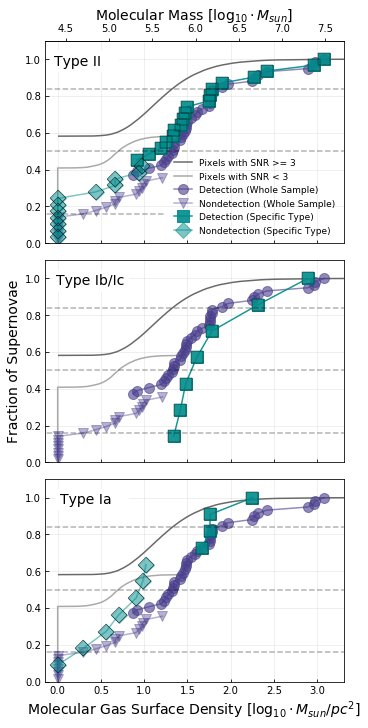

In [11]:
# now redo for each SNe type!

# Make Figure 2
fig, axs = plt.subplots(3, 1, sharex=True, constrained_layout=True)
fig.set_figheight(10)
fig.set_figwidth(5)

axs[0].plot(logSigmaDetecSunCDF, ysigdetec, color = 'dimgrey', linestyle = '-', label = 'Pixels with SNR >= 3')
axs[0].plot(logSigmaNoDetecSunCDF, ysignodetec, color = 'darkgrey', linestyle = '-', label = 'Pixels with SNR < 3')
axs[0].plot(np.log10(CDFdetec3), ydetec3, color = 'darkslateblue',marker = 'o', ms = 10, alpha = 0.6, label = 'Detection (Whole Sample)')
axs[0].plot(logCDF3, ynodetec3, color = 'darkslateblue', marker = 'v', ms = 10, alpha = 0.4, label = 'Nondetection (Whole Sample)')
axs[0].plot(logCDF_d_II_3, ydetec_II_3, color = 'darkcyan', marker = 's', ms = 12, alpha = 0.9, label = 'Detection (Specific Type)')
axs[0].plot(logCDF_nd_II_3, ynodetec_II_3, color = 'darkcyan', marker = 'D', ms = 12, alpha = 0.5, label = 'Nondetection (Specific Type)')
axs[0].plot(logCDF_d_II_3, ydetec_II_3, color = 'None', marker = 's', ms = 12, mec = 'k', mew = 0.4)
axs[0].plot(logCDF_nd_II_3, ynodetec_II_3, color = 'None', marker = 'D', ms = 12, mec = 'k', mew = 0.4)

axs[0].axhline(y=0.16, xmin=-0.3, xmax = 0.4, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.50, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
axs[0].axhline(y=0.84, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
axs[0].set_xlim(-0.15, np.log10(CDFdetec1[-1] + 50))
#axs[0].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 12)
secax0 = axs[0].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
secax0.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 14)
#axs[0].set_ylabel('Fraction of Supernovae', fontsize = 12)
axs[0].annotate('Type II   ', xy=(70, 189), xycoords='axes points',
            size=14, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))
axs[0].set_ylim(0.0, 1.1)
axs[0].tick_params(axis='both', direction='in')
axs[0].legend(frameon=False,loc='best', fontsize = 9, facecolor='white', framealpha=1)
axs[0].grid(True, alpha = 0.25)

axs[1].plot(logSigmaDetecSunCDF, ysigdetec, color = 'dimgrey', linestyle = '-')
axs[1].plot(logSigmaNoDetecSunCDF, ysignodetec, color = 'darkgrey', linestyle = '-')
axs[1].plot(np.log10(CDFdetec3), ydetec3, color = 'darkslateblue',marker = 'o', ms = 10, alpha = 0.6)
axs[1].plot(logCDF3, ynodetec3, color = 'darkslateblue', marker = 'v', ms = 10, alpha = 0.4)
axs[1].plot(logCDF_d_Ibc_3, ydetec_Ibc_3, color = 'darkcyan', marker = 's', ms = 12, alpha = 0.9)
axs[1].plot(logCDF_nd_Ibc_3, ynodetec_Ibc_3, color = 'darkcyan', marker = 'D', ms = 12, alpha = 0.5)
axs[1].plot(logCDF_d_Ibc_3, ydetec_Ibc_3, color = 'None', marker = 's', ms = 12, mec = 'k', mew = 0.4)
axs[1].plot(logCDF_nd_Ibc_3, ynodetec_Ibc_3, color = 'None', marker = 'D', ms = 12, mec = 'k', mew = 0.4)
axs[1].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetec2[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetec2[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetec2[-1]+1000), ls = '--', color = 'k', alpha = 0.3)
axs[1].set_xlim(-0.15, logCDFa[-1] + 50)
#axs[1].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 12)
#secax1 = axs[1].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
#secax1.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)
axs[1].set_xlim(-0.15, np.log10(CDFdetec2[-1] + 1000))
axs[1].set_ylabel('Fraction of Supernovae', fontsize = 14)
axs[1].annotate('Type Ib/Ic', xy=(80, 189), xycoords='axes points',
            size=14, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))
axs[1].set_ylim(0.0, 1.1)
axs[1].tick_params(axis='both', direction='in')
axs[1].grid(True, alpha = 0.25)


axs[2].plot(logSigmaDetecSunCDF, ysigdetec, color = 'dimgrey', linestyle = '-', label = 'Pixels with SNR >= 3')
axs[2].plot(logSigmaNoDetecSunCDF, ysignodetec, color = 'darkgrey', linestyle = '-', label = 'Pixels with SNR < 3')
axs[2].plot(np.log10(CDFdetec3), ydetec3, color = 'darkslateblue',marker = 'o', ms = 10, alpha = 0.6, label = 'Detection (Whole Sample)')
axs[2].plot(logCDF3, ynodetec3, color = 'darkslateblue', marker = 'v', ms = 10, alpha = 0.4, label = 'Upper Limit (Whole Sample)')
axs[2].plot(logCDF_d_Ia_3, ydetec_Ia_3, color = 'darkcyan', marker = 's', ms = 12, alpha = 0.9, label = 'Detection (Specific Type)')
axs[2].plot(logCDF_nd_Ia_3, ynodetec_Ia_3, color = 'darkcyan', marker = 'D', ms = 12, alpha = 0.5, label = 'Upper Limit (Specific Type)')
axs[2].plot(logCDF_d_Ia_3, ydetec_Ia_3, color = 'None', marker = 's', ms = 12, mec = 'k', mew = 0.4)
axs[2].plot(logCDF_nd_Ia_3, ynodetec_Ia_3, color = 'None', marker = 'D', ms = 12, mec = 'k', mew = 0.4)
axs[2].axhline(y=0.16, xmin=-0.3, xmax = np.log10(CDFdetec3[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].axhline(y=0.50, xmin=-0.3, xmax = np.log10(CDFdetec3[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].axhline(y=0.84, xmin=-0.3, xmax = np.log10(CDFdetec3[-1]+100), ls = '--', color = 'k', alpha = 0.3)
axs[2].set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 14)
#secax2 = axs[2].secondary_xaxis('top', functions=(mgsd2mass, mass2mgsd))
#secax2.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)
axs[2].set_xlim(-0.15, np.log10(CDFdetec2[-1] + 100))
axs[2].set_ylim(0.0, 1.1)
axs[2].grid(True, alpha = 0.25)
axs[2].tick_params(axis='both', direction='in')
#axs[2].set_ylabel('Fraction of Supernovae', fontsize = 12)
#axs[2].legend(frameon=False,loc='best', fontsize = 9.5, facecolor='white', framealpha=1)
axs[2].annotate('Type Ia   ', xy=(80, 189), xycoords='axes points',
            size=14, ha='right', va='top', 
            bbox=dict(boxstyle='round', fc='w',edgecolor='none'))
plt.savefig('../Figures/COEmissionByTypeCDFs.png')
plt.show()


In [12]:
Yarray1 = np.concatenate((ynodetec_II_3, ydetec_II_3))
Xarray1 = np.concatenate((logCDF_nd_II_3,logCDF_d_II_3))

Yarray2 = np.concatenate((ynodetec_Ibc_3, ydetec_Ibc_3))
Xarray2 = np.concatenate((logCDF_nd_Ibc_3,logCDF_d_Ibc_3))

Yarray3 = np.concatenate((ynodetec_Ia_3, ydetec_Ia_3))
Xarray3 = np.concatenate((logCDF_nd_Ia_3,logCDF_d_Ia_3))

stats1  = findStats(Yarray1, Xarray1)
stats2  = findStats(Yarray2, Xarray2)
stats3  = findStats(Yarray3, Xarray3)

print("Topic   Percentiles:[0.05, 0.16, 0.50, 0.84, 0.95]")
print("Type II:", stats1)
print(np.mean(Xarray1))
print()
print("Type Ibc:", stats2)
print(np.mean(Xarray2))
print()
print("Type Ia:", stats3)
print(np.mean(Xarray3))

Topic   Percentiles:[0.05, 0.16, 0.50, 0.84, 0.95]
Type II: [0.0, 0.0, 1.05, 1.78, 2.42]
1.151666350096682

Type Ibc: [1.34, 1.34, 1.48, 2.32, 2.89]
1.8336386982656896

Type Ia: [0.0, 0.3, 0.98, 1.76, 1.76]
1.0828923133285642


In [23]:
allYArray = np.concatenate((ysignodetec,ysigdetec))
print(allYArray)
sortAllY=np.sort(allYArray)

allPixArray = np.concatenate((sigmaNoDetecSunCDF,sigmaDetecSunCDF))
sortAllPix=np.sort(allPixArray)

logPix = np.log10(allPixArray)

[0.00000000e+00 1.41849770e-07 2.83699539e-07 ... 9.99999724e-01
 9.99999862e-01 1.00000000e+00]


/Users/nessmayker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


In [49]:
#logSigmaDetecSunCDF  OR (sigmaDetecSunCDF)
#logSigmaNoDetecSunCDF OR(sigmaNoDetecSunCDF)

#axs[0].plot(logdetecCDF, ydetec, color = 'dimgrey', linestyle = '-', label = 'Pixels with SNR >= 3')
#axs[0].plot(lognodetecCDF, ynodetec, color = 'darkgrey', linestyle = '-', label = 'Pixels with SNR < 3')

AllCDF, yCDF = makeCDF(ints, min=0.0) 
logAllCDF = np.log10(AllCDF)

# now redo for each SNe type!

II = mgsd2mass(logCDF_d_II_3)
Ibc= mgsd2mass(logCDF_d_Ibc_3)
Ia = mgsd2mass(logCDF_d_Ia_3)
allTypes = mgsd2mass(np.log10(CDFdetec3))
allPix  = mgsd2mass(logSigmaDetecSunCDF)
print(II)

/Users/nessmayker/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


[5.3203315  5.45606665 5.60384176 5.66100078 5.74407886 5.74702847
 5.83120757 5.85133667 5.87529241 5.90396289 6.16089637 6.16789115
 6.19075426 6.31042527 6.68005068 6.82293938 7.36519779 7.48809882]


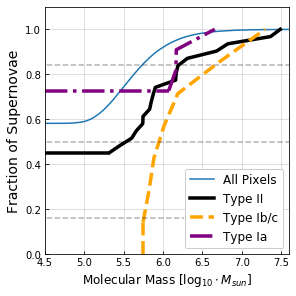

In [75]:

# Make Figure 2
fig, axs = plt.subplots(1, 1, sharex=True, constrained_layout=True)
fig.set_figheight(4)
fig.set_figwidth(4)

#axs.plot(allPixArray, allYArray)
axs.plot(allPix, ysigdetec, label='All Pixels')
#axs.plot(allTypes, ydetec3, color = 'darkslateblue',marker = 'o', ms = 10, alpha = 0.6, label = 'Entire Sample')
axs.plot(II, ydetec_II_3, color = 'black', linewidth = 3.5, marker = '', ms = 10, alpha = 1, label = 'Type II')
#axs.plot(II, ydetec_II_3, color = 'None', marker = 'o', ms = 10, mec = 'k', mew = 0.4)
axs.plot(Ibc, ydetec_Ibc_3, color = 'orange', linewidth = 3.5, linestyle= '--', marker = '', ms = 12, alpha = 1, label = 'Type Ib/c')
#axs.plot(Ibc, ydetec_Ibc_3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)
axs.plot(Ia, ydetec_Ia_3, color = 'purple', linewidth = 3.5, linestyle= '-.', marker = '', ms = 12, alpha = 1, label = 'Type Ia')
#axs.plot(Ia, ydetec_Ia_3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)

ybc = [0,0.142857]
xbc = [5.747620460871383,5.747620460871383]
axs.plot(xbc,ybc, ls = '--', color = 'orange', linewidth=3.5)

axs.axhline(y=0.4516129032258065, xmin=0, xmax = 0.26, color = 'black', linewidth=3.5)
axs.axhline(y=0.7272727272727273, xmin=0, xmax = 0.51, ls = '-.', color = 'purple', linewidth=3.5)
axs.axhline(y=0.16, xmin=-0.3, xmax = 0.57, ls = '--', color = 'k', alpha = 0.3)
axs.axhline(y=0.50, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
axs.axhline(y=0.84, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
#axs.axvspan(5.0,8, ymin=0.0, ymax=1.1, alpha=0.15, color='green')
#axs.set_xlim(-0.15, np.log10(CDFdetec1[-1] + 50))

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
#axs.set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 12)
axs.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)

# secax0 = axs.secondary_xaxis('bottom', functions=(mgsd2mass, mass2mgsd))
# secax0.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 14)
axs.set_xlim(4.5, 7.6)
#axs.set_ylim(0.0, 1.1)
#axs.set_xlim(-2, 7.6)
axs.set_ylim(0.0, 1.1)
axs.tick_params(axis='both', direction='in')
axs.legend(frameon=True,loc='best', fontsize = 12, facecolor='white', framealpha=1)
axs.grid(True, alpha = 0.5)
axs.set_ylabel('Fraction of Supernovae', fontsize = 14)
secax2.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)

plt.savefig('../Figures/COEmissionByTypeCDFsGroupNoShade.png')
plt.show()


In [ ]:


# Make Figure 2
fig, axs = plt.subplots(1, 1, sharex=True, constrained_layout=True)
fig.set_figheight(4)
fig.set_figwidth(4)

#axs.plot(allPixArray, allYArray)
axs.plot(allPix, ysigdetec, label='All Pixels')
#axs.plot(allTypes, ydetec3, color = 'darkslateblue',marker = 'o', ms = 10, alpha = 0.6, label = 'Entire Sample')
axs.plot(II, ydetec_II_3, color = 'black', linewidth = 3.5, marker = '', ms = 10, alpha = 1, label = 'Type II')
#axs.plot(II, ydetec_II_3, color = 'None', marker = 'o', ms = 10, mec = 'k', mew = 0.4)
axs.plot(Ibc, ydetec_Ibc_3, color = 'orange', linewidth = 3.5, linestyle= '--', marker = '', ms = 12, alpha = 1, label = 'Type Ib/c')
#axs.plot(Ibc, ydetec_Ibc_3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)
axs.plot(Ia, ydetec_Ia_3, color = 'purple', linewidth = 3.5, linestyle= '-.', marker = '', ms = 12, alpha = 1, label = 'Type Ia')
#axs.plot(Ia, ydetec_Ia_3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)

ybc = [0,0.142857]
xbc = [5.747620460871383,5.747620460871383]
axs.plot(xbc,ybc, ls = '--', color = 'orange', linewidth=3.5)

axs.axhline(y=0.4516129032258065, xmin=0, xmax = 0.26, color = 'black', linewidth=3.5)
axs.axhline(y=0.7272727272727273, xmin=0, xmax = 0.51, ls = '-.', color = 'purple', linewidth=3.5)
axs.axhline(y=0.16, xmin=-0.3, xmax = 0.57, ls = '--', color = 'k', alpha = 0.3)
axs.axhline(y=0.50, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
axs.axhline(y=0.84, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
#axs.axvspan(5.0,8, ymin=0.0, ymax=1.1, alpha=0.15, color='green')
#axs.set_xlim(-0.15, np.log10(CDFdetec1[-1] + 50))

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
#axs.set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 12)
axs.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)

# secax0 = axs.secondary_xaxis('bottom', functions=(mgsd2mass, mass2mgsd))
# secax0.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 14)
axs.set_xlim(4.5, 7.6)
#axs.set_ylim(0.0, 1.1)
#axs.set_xlim(-2, 7.6)
axs.set_ylim(0.0, 1.1)
axs.tick_params(axis='both', direction='in')
axs.legend(frameon=True,loc='best', fontsize = 12, facecolor='white', framealpha=1)
axs.grid(True, alpha = 0.5)
axs.set_ylabel('Fraction of Supernovae', fontsize = 14)
secax2.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)

plt.savefig('../Figures/COEmissionByTypeCDFsGroupNoShade.png')
plt.show()


In [ ]:

# Make Figure 2
fig, axs = plt.subplots(1, 1, sharex=True, constrained_layout=True)
fig.set_figheight(4)
fig.set_figwidth(8)

#axs.plot(allPixArray, allYArray)
axs.plot(logAllCDF, yCDF)
#axs.plot(allTypes, ydetec3, color = 'darkslateblue',marker = 'o', ms = 10, alpha = 0.6, label = 'Entire Sample')
axs.plot(II, ydetec_II_3, color = 'black', linewidth = 3.5, marker = '', ms = 10, alpha = 1, label = 'Type II')
#axs.plot(II, ydetec_II_3, color = 'None', marker = 'o', ms = 10, mec = 'k', mew = 0.4)
axs.plot(Ibc, ydetec_Ibc_3, color = 'orange', linewidth = 3.5, linestyle= '--', marker = '', ms = 12, alpha = 1, label = 'Type Ib/c')
#axs.plot(Ibc, ydetec_Ibc_3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)
axs.plot(Ia, ydetec_Ia_3, color = 'purple', linewidth = 3.5, linestyle= '-.', marker = '', ms = 12, alpha = 1, label = 'Type Ia')
#axs.plot(Ia, ydetec_Ia_3, color = 'None', marker = 'o', ms = 12, mec = 'k', mew = 0.4)

ybc = [0,0.142857]
xbc = [5.747620460871383,5.747620460871383]
axs.plot(xbc,ybc, ls = '--', color = 'orange', linewidth=3.5)

axs.axhline(y=0.4516129032258065, xmin=0, xmax = 0.043, color = 'black', linewidth=3.5)
axs.axhline(y=0.7272727272727273, xmin=0, xmax = 0.35, ls = '-.', color = 'purple', linewidth=3.5)
axs.axhline(y=0.16, xmin=-0.3, xmax = 0.57, ls = '--', color = 'k', alpha = 0.3)
axs.axhline(y=0.50, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
axs.axhline(y=0.84, xmin=-0.3, xmax = 1.0, ls = '--', color = 'k', alpha = 0.3)
#axs.set_xlim(-0.15, np.log10(CDFdetec1[-1] + 50))

# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
#axs.set_xlabel(r'Molecular Gas Surface Density [$\log_{10} \cdot M_{sun}/pc^2$]', fontsize = 12)
axs.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)

# secax0 = axs.secondary_xaxis('bottom', functions=(mgsd2mass, mass2mgsd))
# secax0.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 14)
#axs.set_xlim(5.2, 7.6)
#axs.set_ylim(0.0, 1.1)
axs.set_xlim(-2, 7.6)
axs.set_ylim(0.0, 1.1)
axs.tick_params(axis='both', direction='in')
#axs.legend(frameon=True,loc='best', fontsize = 12, facecolor='white', framealpha=1)
axs.grid(True, alpha = 0.5)
axs.set_ylabel('Fraction of Supernovae', fontsize = 14)
secax2.set_xlabel(r'Molecular Mass [$\log_{10} \cdot M_{sun}$]', fontsize = 12)

plt.savefig('../Figures/COEmissionByTypeCDFsGroup.png')
plt.show()
